In [386]:
import sys, os
sys.path.insert(0, '/Users/livestorborg/Desktop/FYS-STK4155/project2/code')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from src.neural_network import NeuralNetwork
from src.activations import Sigmoid, ReLU, LeakyReLU, Linear
from src.losses import MSE
from src.optimizers import Adam, RMSprop
from src.training import train
from src.metrics import mse
from src.utils import runge, scale_data, inverse_scale_y

In [387]:
# Setup
SEED = 42
np.random.seed(SEED)

N = 300
x = np.linspace(-1, 1, N)
y_true = runge(x)
y_noise = y_true + np.random.normal(0, 0.1, N)

In [388]:
TEST_SIZE = 0.2
ETA = 0.0001
LOSS = MSE()
EPOCHS = 500
BATCH_SIZE = 20
NETWORK_INPUT_SIZE = 1

# Setup

In [389]:
# # Split and scale data
# X_train_raw, X_test_raw, y_train_nn, y_test_nn = train_test_split(
#     x.reshape(-1, 1), y_noise.reshape(-1, 1), 
#     test_size=0.2, random_state=SEED
# )

# X_train_s, y_train_s, X_mean, X_std, y_mean = scale_data(X_train_raw, y_train_nn)
# X_test_s, y_test_s, _, _, _ = scale_data(X_test_raw, y_test_nn, X_mean, X_std, y_mean)

# # Compute real y values
# y_train_real = inverse_scale_y(y_train_s, y_mean)
# y_test_real = inverse_scale_y(y_test_s, y_mean)

In [390]:
# Define your architecture grid

n_layers_list = np.asarray([2, 3, 4, 5])
n_neurons_list = np.asarray([20, 40, 60, 80, 100])

# Map activation names to classes
activation_map = {
    'sigmoid': Sigmoid(),
    'relu': ReLU(),
    'leaky_relu': LeakyReLU()
}

In [391]:
# Best hyperparameters from part b) - UPDATE THESE!
best_eta = 0.001  # Replace with your best from part b)
best_optimizer = 'adam'  # or 'rmsprop'

In [392]:
# Storage for results
results = {}
all_models = {}

# Number of trials per architecture
N_TRIALS = 5

# Loop through each activation function
for activation_name, activation_func in activation_map.items():
    print(f"\n{'='*60}")
    print(f"Training with {activation_name.upper()} activation")
    print(f"{'='*60}")
    
    # Create matrices to store MSE values (mean and std)
    train_mse_mean = np.zeros((len(n_layers_list), len(n_neurons_list)))
    test_mse_mean = np.zeros((len(n_layers_list), len(n_neurons_list)))
    train_mse_std = np.zeros((len(n_layers_list), len(n_neurons_list)))
    test_mse_std = np.zeros((len(n_layers_list), len(n_neurons_list)))
    
    models_grid = [[None for _ in range(len(n_neurons_list))] 
                   for _ in range(len(n_layers_list))]
    
    # Loop through architectures
    for i, n_layers in enumerate(n_layers_list):
        for j, n_neurons in enumerate(n_neurons_list):
            
            train_mse_trials = []
            test_mse_trials = []
            
            # Run multiple trials with different seeds
            for trial in range(N_TRIALS):
                # Create unique seed for this trial
                trial_seed = SEED + trial * 1000 + i * 100 + j
                
                # ✅ FIXED: Proper Train / Val / Test split (60% / 20% / 20%)
                # First split: Train+Val vs Test (80/20)
                X_temp, X_test_raw, y_temp, y_test_nn = train_test_split(
                    x.reshape(-1, 1), y_noise.reshape(-1, 1),
                    test_size=0.2,
                    random_state=trial_seed
                )
                
                # Second split: Train vs Val (75/25 of remaining = 60/20 overall)
                X_train_raw, X_val_raw, y_train_nn, y_val_nn = train_test_split(
                    X_temp, y_temp,
                    test_size=0.25,  # 25% of 80% = 20% overall
                    random_state=trial_seed
                )
                
                # Scale all three sets using training statistics
                X_train_s, y_train_s, X_mean, X_std, y_mean = scale_data(
                    X_train_raw, y_train_nn
                )
                X_val_s, y_val_s, _, _, _ = scale_data(
                    X_val_raw, y_val_nn, X_mean, X_std, y_mean
                )
                X_test_s, y_test_s, _, _, _ = scale_data(
                    X_test_raw, y_test_nn, X_mean, X_std, y_mean
                )
                
                # Compute real y values for all sets
                y_train_real = inverse_scale_y(y_train_s, y_mean)
                y_val_real = inverse_scale_y(y_val_s, y_mean)
                y_test_real = inverse_scale_y(y_test_s, y_mean)
                
                # Define the architecture
                hidden_layers = [n_neurons] * n_layers
                activations = [activation_func for _ in range(n_layers)] + [Linear()]
                
                # Initialize neural network
                model = NeuralNetwork(
                    network_input_size=1,
                    layer_output_sizes=hidden_layers + [1],
                    activations=activations,
                    loss=MSE(),
                    seed=trial_seed,
                    lambda_reg=0.0,
                    reg_type=None,
                    weight_init='normal'
                )
                
                # Choose optimizer
                if best_optimizer == 'adam':
                    optimizer = Adam(eta=best_eta)
                else:
                    optimizer = RMSprop(eta=best_eta)
                
                # ✅ FIXED: Train with VALIDATION set (not test set!)
                train(
                    nn=model,
                    X_train=X_train_s,
                    y_train=y_train_s,
                    X_val=X_val_s,      # ← Now using validation set
                    y_val=y_val_s,      # ← Not test set!
                    optimizer=optimizer,
                    epochs=500,
                    batch_size=32,
                    stochastic=True,
                    task='regression',
                    early_stopping=True,  # Can enable if needed
                    patience=150,
                    verbose=False,
                    seed=trial_seed
                )
                
                # Store model from last trial
                if trial == N_TRIALS - 1:
                    models_grid[i][j] = model
                
                # ✅ FIXED: Evaluate on truly unseen TEST set
                y_train_pred = inverse_scale_y(model.predict(X_train_s), y_mean)
                y_test_pred = inverse_scale_y(model.predict(X_test_s), y_mean)
                
                train_mse_val = mse(y_train_real, y_train_pred)
                test_mse_val = mse(y_test_real, y_test_pred)
                
                # Store trial results
                train_mse_trials.append(train_mse_val)
                test_mse_trials.append(test_mse_val)
            
            # Compute mean and std across trials
            train_mse_mean[i, j] = np.mean(train_mse_trials)
            test_mse_mean[i, j] = np.mean(test_mse_trials)
            train_mse_std[i, j] = np.std(train_mse_trials)
            test_mse_std[i, j] = np.std(test_mse_trials)
            
            print(f"Layers: {n_layers}, Neurons: {n_neurons:3d} | "
                  f"Train MSE: {train_mse_mean[i, j]:.6f} ± {train_mse_std[i, j]:.6f}, "
                  f"Test MSE: {test_mse_mean[i, j]:.6f} ± {test_mse_std[i, j]:.6f}")
    
    # Store results for this activation function
    results[activation_name] = {
        'train_mse': train_mse_mean,
        'test_mse': test_mse_mean,
        'train_mse_std': train_mse_std,
        'test_mse_std': test_mse_std,
        'models': models_grid
    }
    all_models[activation_name] = models_grid

# Save results to file with metadata
save_data = {
    'results': results,
    'n_layers_list': n_layers_list,
    'n_neurons_list': n_neurons_list,
    'N_TRIALS': N_TRIALS,
    'best_eta': best_eta,
    'best_optimizer': best_optimizer,
    'SEED': SEED
}
np.save('architecture_search_results.npy', save_data)
print("\n✅ Training complete! Results saved to 'architecture_search_results.npy'")
print(f"   Averaged over {N_TRIALS} trials per architecture")



Training with SIGMOID activation
Layers: 2, Neurons:  20 | Train MSE: 0.014900 ± 0.003683, Test MSE: 0.012997 ± 0.004545
Layers: 2, Neurons:  40 | Train MSE: 0.011601 ± 0.001670, Test MSE: 0.012791 ± 0.001953
Layers: 2, Neurons:  60 | Train MSE: 0.010973 ± 0.000893, Test MSE: 0.010929 ± 0.002376
Layers: 2, Neurons:  80 | Train MSE: 0.011826 ± 0.001679, Test MSE: 0.012610 ± 0.001386
Layers: 2, Neurons: 100 | Train MSE: 0.010522 ± 0.001772, Test MSE: 0.011750 ± 0.001471
Layers: 3, Neurons:  20 | Train MSE: 0.012928 ± 0.004147, Test MSE: 0.013219 ± 0.004494
Layers: 3, Neurons:  40 | Train MSE: 0.011654 ± 0.000714, Test MSE: 0.011831 ± 0.001552
Layers: 3, Neurons:  60 | Train MSE: 0.011569 ± 0.002234, Test MSE: 0.012747 ± 0.003181
Layers: 3, Neurons:  80 | Train MSE: 0.010917 ± 0.001897, Test MSE: 0.010967 ± 0.001928
Layers: 3, Neurons: 100 | Train MSE: 0.009783 ± 0.000513, Test MSE: 0.011129 ± 0.001413
Layers: 4, Neurons:  20 | Train MSE: 0.010370 ± 0.001217, Test MSE: 0.011435 ± 0.00228

# Load Previous Results

If you've already run the training and want to load previous results instead of retraining, run this cell. Otherwise, skip it and run the training cell above.

In [393]:
# Load results from file
import os

results_file = 'architecture_search_results.npy'

if os.path.exists(results_file):
    # Load the saved data
    loaded_data = np.load(results_file, allow_pickle=True).item()
    
    # Extract results and metadata
    results = loaded_data['results']
    n_layers_list = loaded_data['n_layers_list']
    n_neurons_list = loaded_data['n_neurons_list']
    N_TRIALS = loaded_data['N_TRIALS']
    best_eta = loaded_data['best_eta']
    best_optimizer = loaded_data['best_optimizer']
    SEED = loaded_data['SEED']
    
    print("✅ Successfully loaded results from file!")
    print(f"   Configuration: {len(n_layers_list)} layer options × {len(n_neurons_list)} neuron options")
    print(f"   Averaged over {N_TRIALS} trials")
    print(f"   Hyperparameters: eta={best_eta}, optimizer={best_optimizer}")
    print(f"\nActivation functions loaded:")
    for activation_name in results.keys():
        print(f"   - {activation_name}")
else:
    print(f"❌ Results file '{results_file}' not found!")
    print("   Please run the training cell first to generate results.")

✅ Successfully loaded results from file!
   Configuration: 4 layer options × 5 neuron options
   Averaged over 5 trials
   Hyperparameters: eta=0.001, optimizer=adam

Activation functions loaded:
   - sigmoid
   - relu
   - leaky_relu


# Visualization and Analysis

The cells below will use the loaded results (either from training above or from file) to create visualizations and analysis.

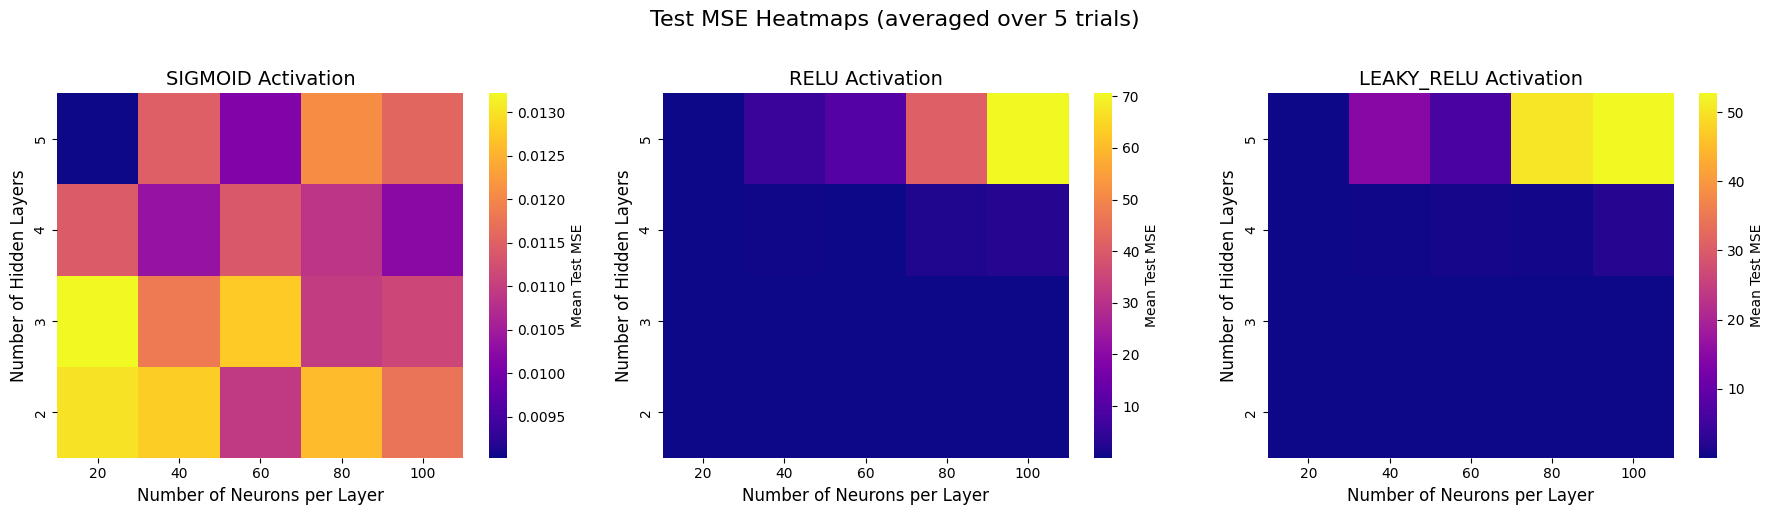

In [394]:
# Create heatmaps for TEST MSE (mean across trials)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, activation_name in enumerate(['sigmoid', 'relu', 'leaky_relu']):
    ax = axes[idx]
    
    # Create heatmap using mean test MSE
    # We want the number of hidden layers to increase upward on the y-axis.
    # seaborn.heatmap by default puts the first row at the top, so we'll flip the
    # data vertically and set the yticklabels in the reversed order to reflect
    # increasing layer counts from bottom to top.
    heatmap_data = results[activation_name]['test_mse'][::-1, :]
    ytick_labels = list(reversed(n_layers_list))

    sns.heatmap(
        heatmap_data,
        annot=False,
        fmt='.4f',
        cmap='plasma',  # Darker = better (lower MSE)
        xticklabels=n_neurons_list,
        yticklabels=ytick_labels,
        ax=ax,
        cbar_kws={'label': 'Mean Test MSE'}
    )
    
    ax.set_xlabel('Number of Neurons per Layer', fontsize=12)
    ax.set_ylabel('Number of Hidden Layers', fontsize=12)
    ax.set_title(f'{activation_name.upper()} Activation', fontsize=14)

plt.suptitle(f'Test MSE Heatmaps (averaged over {N_TRIALS} trials)', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('activation_architecture_heatmaps_averaged.png', dpi=300, bbox_inches='tight')
plt.show()

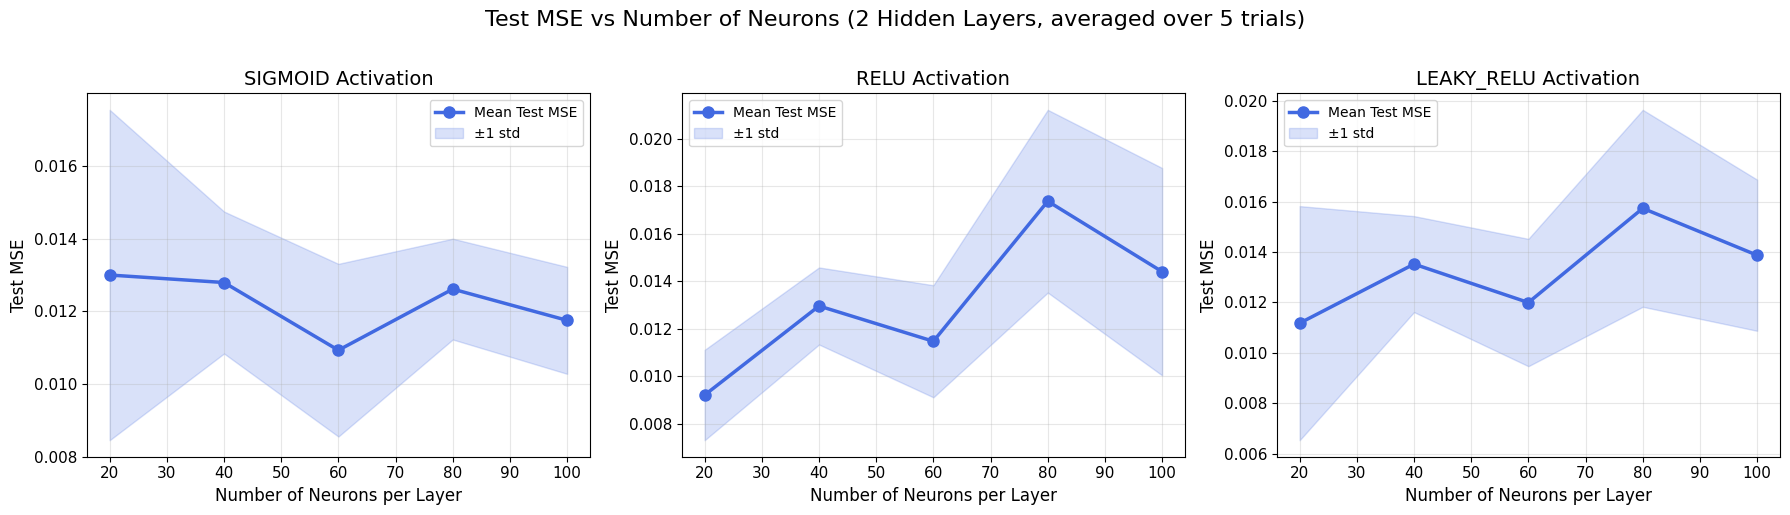


BEST ARCHITECTURES WITH 2 HIDDEN LAYERS

SIGMOID:
  Best neurons: 60
  Test MSE:  0.010929 ± 0.002376

RELU:
  Best neurons: 20
  Test MSE:  0.009199 ± 0.001903

LEAKY_RELU:
  Best neurons: 20
  Test MSE:  0.011179 ± 0.004644


In [395]:
# Plot MSE evolution with number of neurons for a fixed number of hidden layers
fixed_n_layers = 2  # Choose the number of hidden layers to analyze

# Find the index of this layer count in n_layers_list
if fixed_n_layers in n_layers_list:
    layer_idx = np.where(np.array(n_layers_list) == fixed_n_layers)[0][0]
    
    # Create subplots - one for each activation function
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot line for each activation function in separate subplot
    for idx, activation_name in enumerate(['sigmoid', 'relu', 'leaky_relu']):
        ax = axes[idx]
        
        # Get mean and std for test MSE
        test_mse_mean = results[activation_name]['test_mse'][layer_idx, :]
        test_mse_std = results[activation_name]['test_mse_std'][layer_idx, :]
        
        # Plot test MSE with shaded std region
        ax.plot(n_neurons_list, test_mse_mean, 
                marker='o', linewidth=2.5, markersize=8,
                color='royalblue', linestyle='-', label='Mean Test MSE')
        
        # Add shaded region for ± 1 standard deviation
        ax.fill_between(n_neurons_list, 
                        test_mse_mean - test_mse_std, 
                        test_mse_mean + test_mse_std,
                        color='royalblue', alpha=0.2, label='±1 std')
        
        ax.set_xlabel('Number of Neurons per Layer', fontsize=12)
        ax.set_ylabel('Test MSE', fontsize=12)
        ax.set_title(f'{activation_name.upper()} Activation', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=11)
        ax.legend(fontsize=10)
    
    plt.suptitle(f'Test MSE vs Number of Neurons ({fixed_n_layers} Hidden Layer{"s" if fixed_n_layers > 1 else ""}, averaged over {N_TRIALS} trials)', 
                 fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(f'test_mse_vs_neurons_{fixed_n_layers}layers_averaged.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print the best configuration for each activation
    print(f"\n{'='*60}")
    print(f"BEST ARCHITECTURES WITH {fixed_n_layers} HIDDEN LAYER{'S' if fixed_n_layers > 1 else ''}")
    print(f"{'='*60}")
    for activation_name in ['sigmoid', 'relu', 'leaky_relu']:
        test_mse_mean = results[activation_name]['test_mse'][layer_idx, :]
        test_mse_std = results[activation_name]['test_mse_std'][layer_idx, :]
        
        best_neuron_idx = np.argmin(test_mse_mean)
        best_neurons = n_neurons_list[best_neuron_idx]
        best_test_mse = test_mse_mean[best_neuron_idx]
        best_test_std = test_mse_std[best_neuron_idx]
        
        print(f"\n{activation_name.upper()}:")
        print(f"  Best neurons: {best_neurons}")
        print(f"  Test MSE:  {best_test_mse:.6f} ± {best_test_std:.6f}")
else:
    print(f"Error: {fixed_n_layers} layers not found in n_layers_list: {n_layers_list}")
    print("Please choose a value from the list above.")

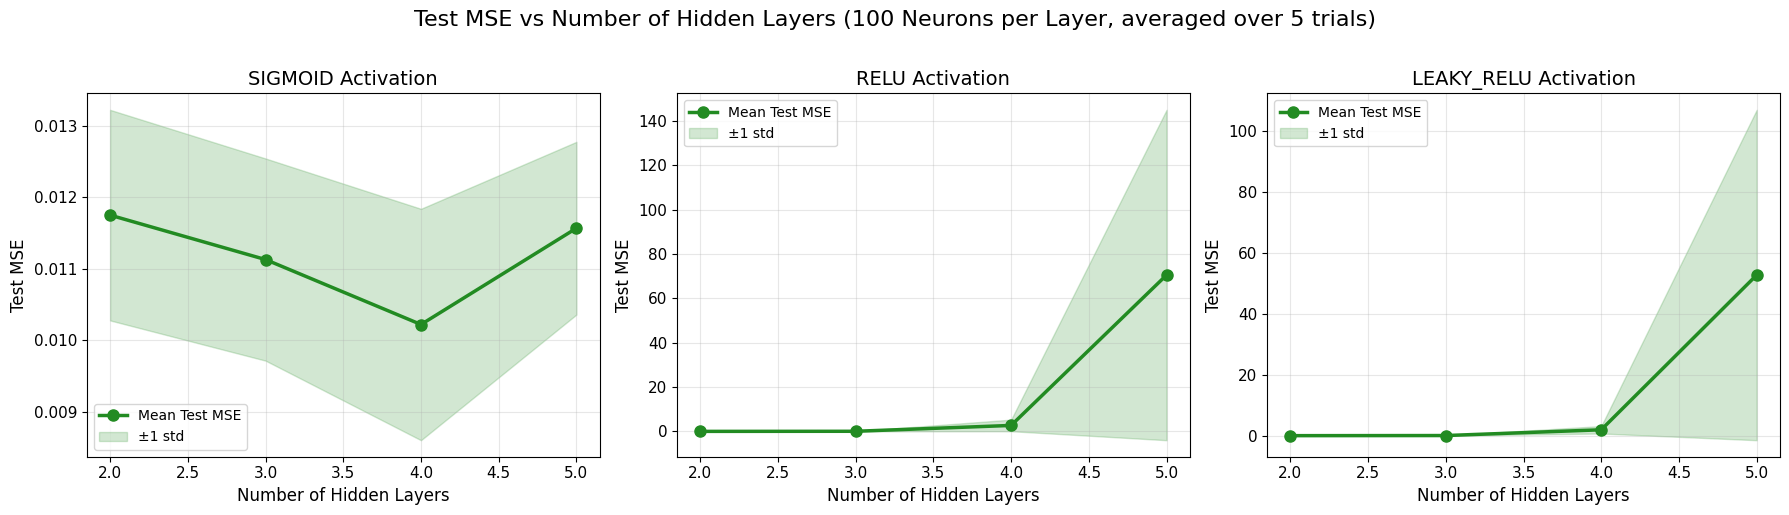


BEST ARCHITECTURES WITH 100 NEURONS PER LAYER

SIGMOID:
  Best number of layers: 4
  Test MSE:  0.010221 ± 0.001617

RELU:
  Best number of layers: 2
  Test MSE:  0.014394 ± 0.004366

LEAKY_RELU:
  Best number of layers: 2
  Test MSE:  0.013874 ± 0.002999


In [396]:
# Plot MSE evolution with number of layers for a fixed number of neurons
fixed_n_neurons = 100  # Choose the number of neurons to analyze

# Find the index of this neuron count in n_neurons_list
if fixed_n_neurons in n_neurons_list:
    neuron_idx = np.where(np.array(n_neurons_list) == fixed_n_neurons)[0][0]
    
    # Create subplots - one for each activation function
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot line for each activation function in separate subplot
    for idx, activation_name in enumerate(['sigmoid', 'relu', 'leaky_relu']):
        ax = axes[idx]
        
        # Get mean and std for test MSE
        test_mse_mean = results[activation_name]['test_mse'][:, neuron_idx]
        test_mse_std = results[activation_name]['test_mse_std'][:, neuron_idx]
        
        # Plot test MSE with shaded std region
        ax.plot(n_layers_list, test_mse_mean, 
                marker='o', linewidth=2.5, markersize=8,
                color='forestgreen', linestyle='-', label='Mean Test MSE')
        
        # Add shaded region for ± 1 standard deviation
        ax.fill_between(n_layers_list, 
                        test_mse_mean - test_mse_std, 
                        test_mse_mean + test_mse_std,
                        color='forestgreen', alpha=0.2, label='±1 std')
        
        ax.set_xlabel('Number of Hidden Layers', fontsize=12)
        ax.set_ylabel('Test MSE', fontsize=12)
        ax.set_title(f'{activation_name.upper()} Activation', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=11)
        ax.legend(fontsize=10)
    
    plt.suptitle(f'Test MSE vs Number of Hidden Layers ({fixed_n_neurons} Neurons per Layer, averaged over {N_TRIALS} trials)', 
                 fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(f'test_mse_vs_layers_{fixed_n_neurons}neurons_averaged.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print the best configuration for each activation
    print(f"\n{'='*60}")
    print(f"BEST ARCHITECTURES WITH {fixed_n_neurons} NEURONS PER LAYER")
    print(f"{'='*60}")
    for activation_name in ['sigmoid', 'relu', 'leaky_relu']:
        test_mse_mean = results[activation_name]['test_mse'][:, neuron_idx]
        test_mse_std = results[activation_name]['test_mse_std'][:, neuron_idx]
        
        best_layer_idx = np.argmin(test_mse_mean)
        best_layers = n_layers_list[best_layer_idx]
        best_test_mse = test_mse_mean[best_layer_idx]
        best_test_std = test_mse_std[best_layer_idx]
        
        print(f"\n{activation_name.upper()}:")
        print(f"  Best number of layers: {best_layers}")
        print(f"  Test MSE:  {best_test_mse:.6f} ± {best_test_std:.6f}")
else:
    print(f"Error: {fixed_n_neurons} neurons not found in n_neurons_list: {n_neurons_list}")
    print("Please choose a value from the list above.")

In [397]:
# Summary: Find the best architecture for each activation function
print("="*80)
print(f"BEST ARCHITECTURES SUMMARY (averaged over {N_TRIALS} trials)")
print("="*80)

for activation_name in ['sigmoid', 'relu', 'leaky_relu']:
    # Get mean and std matrices
    test_mse_matrix = results[activation_name]['test_mse']
    test_mse_std_matrix = results[activation_name]['test_mse_std']
    train_mse_matrix = results[activation_name]['train_mse']
    train_mse_std_matrix = results[activation_name]['train_mse_std']
    
    # Find the best architecture (minimum mean test MSE)
    best_idx = np.unravel_index(np.argmin(test_mse_matrix), test_mse_matrix.shape)
    best_n_layers = n_layers_list[best_idx[0]]
    best_n_neurons = n_neurons_list[best_idx[1]]
    
    # Get mean and std for best architecture
    best_test_mse_mean = test_mse_matrix[best_idx]
    best_test_mse_std = test_mse_std_matrix[best_idx]
    best_train_mse_mean = train_mse_matrix[best_idx]
    best_train_mse_std = train_mse_std_matrix[best_idx]
    
    print(f"\n{activation_name.upper()} Activation:")
    print(f"  Best architecture: {best_n_layers} hidden layer(s), {best_n_neurons} neurons per layer")
    print(f"  Train MSE: {best_train_mse_mean:.6f} ± {best_train_mse_std:.6f}")
    print(f"  Test MSE:  {best_test_mse_mean:.6f} ± {best_test_mse_std:.6f}")
    print(f"  Gap (Test - Train): {(best_test_mse_mean - best_train_mse_mean):.6f}")

print("\n" + "="*80)

BEST ARCHITECTURES SUMMARY (averaged over 5 trials)

SIGMOID Activation:
  Best architecture: 5 hidden layer(s), 20 neurons per layer
  Train MSE: 0.010410 ± 0.000176
  Test MSE:  0.009030 ± 0.001029
  Gap (Test - Train): -0.001380

RELU Activation:
  Best architecture: 2 hidden layer(s), 20 neurons per layer
  Train MSE: 0.010474 ± 0.000911
  Test MSE:  0.009199 ± 0.001903
  Gap (Test - Train): -0.001275

LEAKY_RELU Activation:
  Best architecture: 2 hidden layer(s), 20 neurons per layer
  Train MSE: 0.012207 ± 0.002825
  Test MSE:  0.011179 ± 0.004644
  Gap (Test - Train): -0.001029

